# Copula Demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

## Joint PDF (scatter plot) on original domain vs [0,1] domain

In [2]:
n_pts = 2000
rho = 0.9
Z2 = np.random.normal(size=(n_pts,2))
Z2[:,1] = Z2 @ np.array([rho, np.sqrt(1-rho**2)])

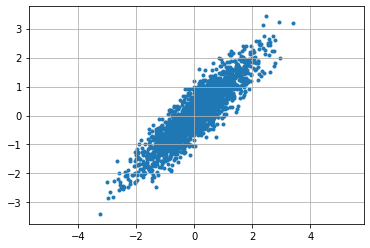

In [3]:
# Plot on the domain of normal distribution [-infty, infty]
plt.scatter(Z2[:,0], Z2[:,1],marker='.')
plt.grid()
plt.axis('equal')
plt.show()

In [4]:
Z2

array([[-1.91117181, -1.68670317],
       [ 0.30017755,  0.65462548],
       [-0.65087092, -1.15892243],
       ...,
       [ 0.54529806,  0.07659536],
       [-1.22524238, -1.78485166],
       [ 1.03458976,  1.07691952]])

In [5]:
U2 = ss.norm.cdf(Z2)
U2

array([[0.02799125, 0.04583022],
       [0.61797913, 0.74364554],
       [0.25756491, 0.1232439 ],
       ...,
       [0.70722573, 0.53052728],
       [0.11024195, 0.03714269],
       [0.84956973, 0.85924189]])

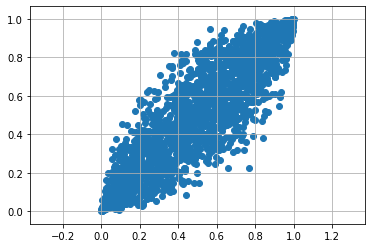

In [6]:
# Plot on the domain of uniform distribution [0,1]
plt.scatter(U2[:,0], U2[:,1])
plt.grid()
plt.axis('equal')
#plt.axis([0,1,0,1])
plt.show()

## Now apply the generated copula to some RVs
### 1. Two Pareto distributions

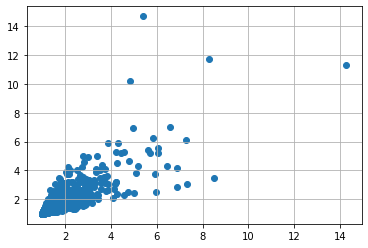

In [7]:
#Pareto distribution is given by
#  CDF = 1 - (lambda/x)^alpha
#     or
#  X = lambda * (1-U)^(-1/alpha)
lam = 1
alpha = 3

X2 = lam * np.power(1-U2, -1/alpha)

plt.scatter(X2[:,0], X2[:,1])
plt.grid()
#plt.axis('equal')
#plt.axis([0,1,0,1])
plt.show()

### 2. Pareto and Normal distributions  (two different distributions)

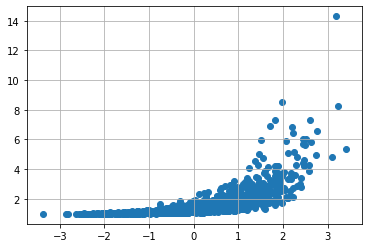

In [8]:
Y1 = ss.norm.ppf(U2[:,1])
Y2 = lam * np.power(1-U2[
    :,0], -1/alpha)

plt.scatter(Y1, Y2)
plt.grid()
#plt.axis('equal')
#plt.axis([0,1,0,1])
plt.show()

### 3. Two exponential distributions representing default time

In [9]:
# Now use the joint pair (U1, U2) pair to the default rate
lam = 1
default = -np.log(U2)/lam

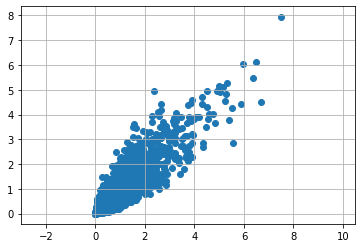

In [10]:
plt.scatter(default[:,0], default[:,1])
plt.grid()
plt.axis('equal')
plt.show()

### 4. Copula can be even applied to random samples
For some distributions, inverse CDF is difficult to compute. But, suppose that we can draw RNs easily.

In [11]:
X1 = ss.ncx2.rvs(5, 4, size=n_pts)
X2 = ss.ncx2.rvs(8, 3, size=n_pts)

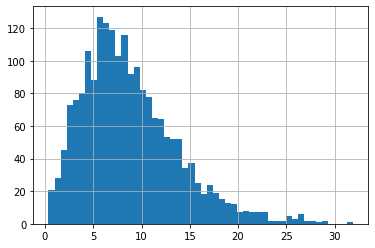

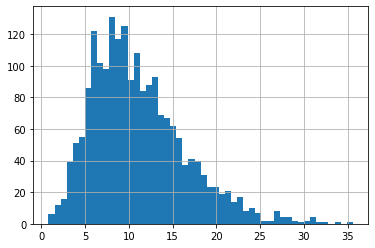

In [12]:
n, bins, patches = plt.hist(X1, 50)
plt.grid(True)
plt.show()
n, bins, patches = plt.hist(X2, 50)
plt.grid(True)
plt.show()

In [13]:
rank1 = np.int16(ss.rankdata(U2[:,0]) - 1)
rank2 = np.int16(ss.rankdata(U2[:,1]) - 1)
print(U2[:,0])
print(rank1, rank2)

[0.02799125 0.61797913 0.25756491 ... 0.70722573 0.11024195 0.84956973]
[  49 1193  453 ... 1387  180 1694] [  79 1449  216 ...  990   65 1714]


In [14]:
X1

array([ 3.31646089, 20.9527306 ,  8.26298009, ...,  1.90807955,
       13.61331907, 16.37358085])

In [15]:

X1

array([ 3.31646089, 20.9527306 ,  8.26298009, ...,  1.90807955,
       13.61331907, 16.37358085])

In [16]:
X1.sort()
X1_rank = X1[np.int16(rank1)]
X2.sort()
X2_rank = X2[np.int16(rank2)]

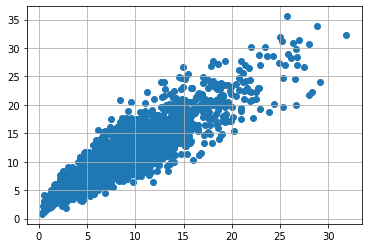

In [17]:
plt.scatter(X1_rank, X2_rank)
plt.grid()
#plt.axis('equal')
#plt.axis([0,1,0,1])
plt.show()

## We write a function generating multi-variate Gaussian copula

In [18]:
def CopulaGaussian(n_var=2, n_sample=1000, rho=0.0):
    corr_mat = np.eye(n_var)*(1.0-rho) + rho
    chol_mat = np.linalg.cholesky(corr_mat)
    Z = np.random.normal(size=(n_sample, n_var)) @ chol_mat.transpose()
    U = ss.norm.cdf(Z)
    return U

In [19]:
## Simple correlation matrix
n_var = 3
rho = 0.75
corr_mat = np.eye(n_var)*(1-rho) + rho
print(corr_mat)

[[1.   0.75 0.75]
 [0.75 1.   0.75]
 [0.75 0.75 1.  ]]


In [20]:
U2 = CopulaGaussian(n_var=2, rho=0.9)

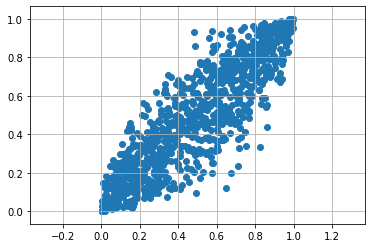

In [21]:
# Test the code
plt.scatter(U2[:,0], U2[:,1])
plt.axis('equal')
plt.grid()
plt.show()

# Simple CDO demo

##### * Assume that the individual loans have the default rate of $\lambda$=0.3 (30% of loans default every year)
* Let's package 10 (possibly sub-prime) loans into our CDO
* Create gaussian copula with rho = 0.5 vs 0.9
* Assume the maturity of our CDO is 1 year. 
* Assume the senior tranche is the bottom 50% of the loan (i.e. not affected by the first 50% loss)

In [22]:
# Gaussian copula 
lam = 0.3
n_sample = 10000
U2 = CopulaGaussian(n_var=10, n_sample=n_sample, rho=0.5)

# Generate RNs for the default time
default_time = -np.log(U2)/lam
print( np.round(default_time, decimals=2) )

[[ 4.13  2.45  2.23 ...  1.1   0.5   4.43]
 [ 5.1   3.16  3.04 ...  5.94  0.16  3.16]
 [ 8.26  7.3   8.54 ...  7.11  4.28  8.99]
 ...
 [ 0.15  1.27  2.04 ...  0.82  0.29  7.36]
 [ 4.95  6.73  7.69 ...  5.8   7.   15.79]
 [ 1.74  1.19  0.81 ...  2.53  1.26  3.39]]


In [23]:
# Check that the average default time of the individual loans are around 3.33 years
print( np.mean(default_time, axis=0) )

[3.35027867 3.3343697  3.34852108 3.32444511 3.3505673  3.37776846
 3.31960508 3.32488943 3.30570484 3.29829761]


In [24]:
# Compute the default ratio for the individual loans within 1 year
# it should be about 20%. Exactly 1-exp(-0.2)
print( "Exact default rate < 1yr:", 1 - np.exp(-lam) )
print( np.mean(default_time < 1.0, axis=0) )

Exact default rate < 1yr: 0.2591817793182821
[0.2566 0.258  0.258  0.2581 0.2646 0.2648 0.2643 0.2613 0.2642 0.2624]


In [25]:
# Expected of individual loan
(1 - np.sum(default_time < 1.0, axis=0) / n_sample)*100  # the percentage of loans survived

array([74.34, 74.2 , 74.2 , 74.19, 73.54, 73.52, 73.57, 73.87, 73.58,
       73.76])

In [26]:
# Count the total defaults in the pool within 1 year
default_total_loan = np.sum(default_time < 1.0, axis=1)
print( default_total_loan )

[1 2 0 ... 6 0 5]


In [27]:
# Compute the percentage of the total default bigger than 5
# This is the probability of the senior tranche having any loss
np.mean(default_total_loan > 5)

0.1669

In [28]:
# We can also compute the expected price of senior tranche (out of 100)
np.mean(np.fmin(10 - default_total_loan, 5))/5.0 * 100

91.47800000000001

## When the correlation is high, the default rate of the senior tranche CDO is just as bad as the individual loans (sub-prime)